In [1]:
# imports
import datetime
import boto3
import time
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import plotly.express as px
import io
import datetime
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_data(): 
    s3 = boto3.client('s3') # comment out when on local
    obj = s3.get_object(Bucket = 'lawyer-predict', Key = 'df.csv')
    data_fnc = pd.read_csv(io.BytesIO(obj['Body'].read()))

    s3_bucket_stuff = boto3.resource('s3')
    bucket = s3_bucket_stuff.Bucket('lawyer-predict')    
    for file in bucket.objects.all():    
        file_date = file.last_modified.replace(tzinfo=None)
    
    return data_fnc, file_date

data_orig, date_modified = load_data()

data = data_orig.copy()

#categorize decisions as acceptance as 1 , waitlisted as 2 or denied as 0
data.loc[data.decision.isin(['Accepted', 'Accepted Attending', 'Accepted Deferred', 'Accepted Deferred Attending', 'Accepted Deferred Withdrawn', 'Accepted Withdrawn']), 'decision_numeric'] = 1

data.loc[data.decision.isin(['Rejected', 'Rejected Attending', 'Rejected Deferred', 'Rejected Withdrawn']), 'decision_numeric'] = 0

data.loc[data.decision.isin(['WL Accepted', 'WL Accepted Attending', 'WL Accepted Deferred', 'WL Accepted Deferred Attending', 'WL Accepted Withdrawn', 'WL Rejected', 'WL Rejected Deferred', 'WL Rejected Withdrawn', 'WL Withdrawn', 'Waitlisted', 'Waitlisted Attending', 'Waitlisted Deferred', 'Waitlisted Withdrawn']), 'decision_numeric'] = 2

data.loc[data.decision.isin(['Intend to Apply', 'Intend to Apply Attending', 'Intend to Apply Deferred Withdrawn', 'Intend to Apply Withdrawn', 'Pending', 'Pending Attending', 'Pending Deferred', 'Pending Deferred Withdrawn', 'Pending Withdrawn']), 'decision_numeric'] = np.nan

data = data.loc[~data.decision_numeric.isna()]
#drop where job experience not given
data = data.loc[data.work_experience != '?']
#label encode work experience
data.loc[data.work_experience == '0 years (KJD)', 'work_experience_encode'] = 0
data.loc[data.work_experience == '1-4 years', 'work_experience_encode'] = 1
data.loc[data.work_experience == '5-9 years', 'work_experience_encode'] = 2
data.loc[data.work_experience == '10+ years', 'work_experience_encode'] = 3

In [3]:
#build and test models based on Vandy

school_name = 'Vanderbilt University'
school_orig = data.loc[data.school == school_name][['decision_numeric', 'gpa', 'lsat', 'urm', 'work_experience_encode', 'cycleid']].dropna().reset_index()
school_orig = school_orig.drop('index', axis = 1)

In [4]:
#baseline model
baseline_train = school_orig.loc[school_orig.cycleid != 17]
#baseline_train_y = baseline_train.decision_numeric.reset_index()
baseline_train_y = baseline_train.decision_numeric

baseline_train_x = baseline_train.drop('decision_numeric', axis =1)

baseline_test = school_orig.loc[school_orig.cycleid == 17] 
baseline_test_y = baseline_test.decision_numeric
baseline_test_x = baseline_test.drop('decision_numeric', axis =1)

print(baseline_train_x.shape)

xgb_baseline = XGBClassifier(num_classes = 3, random_state = 12)
# preds are gpa, lsat, urm, work_experience, 
xgb_baseline.fit(baseline_train_x, baseline_train_y)

f1_score_list = []
log_loss_list = []

f1_score_baseline = f1_score(baseline_test_y, xgb_baseline.predict(baseline_test_x), average = 'micro')
log_loss_baseline = log_loss(baseline_test_y, xgb_baseline.predict_proba(baseline_test_x))

f1_score_list.append(f1_score_baseline)
log_loss_list.append(log_loss_baseline)

print(f1_score_baseline)
print(log_loss_baseline)

(1355, 5)
0.6229508196721312
1.0031850252025685


In [5]:
#duplicate rows for training
cycle16_indicies = baseline_train_x.loc[baseline_train_x.cycleid==16].index
df_cycle16_train = baseline_train_x.iloc[cycle16_indicies]
baseline_train_x = baseline_train_x.append(baseline_train_x.iloc[cycle16_indicies],ignore_index=True)
baseline_train_x = baseline_train_x.append(baseline_train_x.iloc[cycle16_indicies],ignore_index=True)
baseline_train_x = baseline_train_x.append(baseline_train_x.iloc[cycle16_indicies],ignore_index=True)

baseline_train_y = baseline_train_y.append(baseline_train_y.iloc[cycle16_indicies],ignore_index=True)
baseline_train_y = baseline_train_y.append(baseline_train_y.iloc[cycle16_indicies],ignore_index=True)
baseline_train_y = baseline_train_y.append(baseline_train_y.iloc[cycle16_indicies],ignore_index=True)

print(baseline_train_x.shape)
xgb_duplicate = XGBClassifier(num_classes = 3, random_state = 12)
# preds are gpa, lsat, urm, work_experience, 
xgb_duplicate.fit(baseline_train_x, baseline_train_y)

f1_score_duplicate = f1_score(baseline_test_y, xgb_duplicate.predict(baseline_test_x), average = 'micro')
log_loss_duplicate = log_loss(baseline_test_y, xgb_duplicate.predict_proba(baseline_test_x))

f1_score_list.append(f1_score_duplicate)
log_loss_list.append(log_loss_duplicate)

print(f1_score_duplicate)
print(log_loss_duplicate)

(2261, 5)
0.639344262295082
1.0319778619669988


# SMOTE

In [6]:
cycle17_test = school_orig.loc[school_orig.cycleid == 17] # DONT TOUCH
cycle17_train = school_orig.loc[school_orig.cycleid != 17]

smote_cycle_y = cycle17_train['cycleid']#.to_numpy()
smote_cycle_x = cycle17_train.drop('cycleid', axis = 1)#.to_numpy()

samp_dict = {}

for cycle_id_smote in np.unique(smote_cycle_y):
    samp_dict[cycle_id_smote] = smote_cycle_y[smote_cycle_y==cycle_id_smote].shape[0]

samp_dict[np.max(smote_cycle_y)] = samp_dict[np.max(smote_cycle_y)]*2
oversample = SMOTE(sampling_strategy = samp_dict)


X_up, y_up = oversample.fit_resample(smote_cycle_x,smote_cycle_y)

df_resample_train = pd.DataFrame(X_up,columns = smote_cycle_x.columns)

vandy_2018_cycle_train = df_resample_train #vandy_2018_cycle_train.append([df_cycle16]*3,ignore_index=True)
# #SMOTE INSTEAD


school_y = vandy_2018_cycle_train['decision_numeric'].to_numpy()
school_X = vandy_2018_cycle_train.drop(['decision_numeric'], axis = 1).to_numpy()


test_y = cycle17_test['decision_numeric'].to_numpy()
test_x = cycle17_test.drop(['decision_numeric', 'cycleid'], axis = 1).to_numpy()


xgb_smote = XGBClassifier(num_classes = 3, random_state = 12)
# # preds are gpa, lsat, urm, work_experience, 
xgb_smote.fit(school_X, np.round(school_y+.49))

f1_score_smote = f1_score(test_y, xgb_smote.predict(test_x), average = 'micro')
log_loss_smote = log_loss(test_y, xgb_smote.predict_proba(test_x))

f1_score_list.append(f1_score_smote)
log_loss_list.append(log_loss_smote)

print(f1_score_smote)
print(log_loss_smote)

0.6065573770491803
1.041658621479864


/Users/rushilsheth/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (604) in class 16 will be larger than the number of samples in the majority class (class #15 -> 407)



In [7]:
# smotenc on cycle

cycle17_test_smotenc = school_orig.loc[school_orig.cycleid == 17] # DONT TOUCH
cycle17_train_smotenc = school_orig.loc[school_orig.cycleid != 17]

samp_dict = {}

for cycle_id_smote in np.unique(smote_cycle_y):
    samp_dict[cycle_id_smote] = smote_cycle_y[smote_cycle_y==cycle_id_smote].shape[0]
samp_dict[np.max(smote_cycle_y)] = samp_dict[np.max(smote_cycle_y)]*2
oversample = SMOTENC(sampling_strategy = samp_dict, categorical_features = [0,3,4])

smotenc_cycle_y = cycle17_train_smotenc.cycleid
smotenc_cycle_x = cycle17_train_smotenc.drop('cycleid', axis = 1)


X_up, y_up = oversample.fit_resample(smotenc_cycle_x,smotenc_cycle_y)

df_resample_train = pd.DataFrame(X_up,columns = smotenc_cycle_x.columns)

smote_2_y = df_resample_train['decision_numeric'].to_numpy()
smote_2_X = df_resample_train.drop('decision_numeric', axis =1).to_numpy()

# # FIT
xgb_smotenc = XGBClassifier(num_classes = 3, random_state = 12)
# # # preds are gpa, lsat, urm, work_experience, 
xgb_smotenc.fit(smote_2_X, smote_2_y)

test_y = cycle17_test['decision_numeric'].to_numpy()
test_x = cycle17_test.drop(['decision_numeric', 'cycleid'], axis = 1).to_numpy()

f1_score_smotenc = f1_score(test_y, xgb_smotenc.predict(test_x), average = 'micro')
log_loss_smotenc = log_loss(test_y, xgb_smotenc.predict_proba(test_x))

f1_score_list.append(f1_score_smotenc)
log_loss_list.append(log_loss_smotenc)

print(f1_score_smotenc)
print(log_loss_smotenc)

/Users/rushilsheth/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:253: UserWarning:

After over-sampling, the number of samples (604) in class 16 will be larger than the number of samples in the majority class (class #15 -> 407)



0.6229508196721312
1.045362403914027


In [8]:
#smotenc on whole thing
smote_2_y = df_resample_train[['decision_numeric']]

samp_dict_2 = {}
for cycle_id_smote in np.unique(smote_2_y):
    samp_dict_2[cycle_id_smote] = np.max(smote_2_y['decision_numeric'].value_counts())
oversample_2 = SMOTENC(sampling_strategy = samp_dict_2, categorical_features = [2,3])


smote_2_y = smote_2_y.decision_numeric

X_fin, y_fin = oversample_2.fit_resample(smote_2_X,smote_2_y)

xgb_school = XGBClassifier(num_classes = 3, random_state = 12)
# preds are gpa, lsat, urm, work_experience, 
xgb_school.fit(X_fin, y_fin)

f1_score_final = f1_score(test_y, xgb_school.predict(test_x), average = 'micro')
log_loss_final = log_loss(test_y, xgb_school.predict_proba(test_x))

f1_score_list.append(f1_score_final)
log_loss_list.append(log_loss_final)

print(f1_score_final)
print(log_loss_final)

0.639344262295082
0.9800577321830282


In [9]:
import matplotlib.pyplot as plt
f1_score_list

[0.6229508196721312,
 0.639344262295082,
 0.6065573770491803,
 0.6229508196721312,
 0.639344262295082]

In [10]:
log_loss_list

[1.0031850252025685,
 1.0319778619669988,
 1.041658621479864,
 1.045362403914027,
 0.9800577321830282]

In [11]:
x_labels = ['Baseline', 'Duplicate', 'SMOTE', 'SMOTENC', 'SMOTENC twice']

In [12]:
fin_df = df1 = pd.DataFrame(zip(x_labels, f1_score_list, log_loss_list), columns=["label", "f1 score", "log loss"])
fin_df

,label,f1 score,log loss
0,Baseline,0.622951,1.003185
1,Duplicate,0.639344,1.031978
2,SMOTE,0.606557,1.041659
3,SMOTENC,0.622951,1.045362
4,SMOTENC twice,0.639344,0.980058


In [13]:
score_type_f1 = ['f1 score', 'f1 score', 'f1 score', 'f1 score', 'f1 score']
score_type_log = ['log loss', 'log loss', 'log loss', 'log loss', 'log loss']

df1 = pd.DataFrame(zip(x_labels, f1_score_list, score_type_f1), columns=["label", "score", "score type"])
df2 = pd.DataFrame(zip(x_labels, log_loss_list, score_type_log), columns=["label", "score", "score type"])

df = pd.concat([df1,df2],ignore_index=True)
df

,label,score,score type
0,Baseline,0.622951,f1 score
1,Duplicate,0.639344,f1 score
2,SMOTE,0.606557,f1 score
3,SMOTENC,0.622951,f1 score
4,SMOTENC twice,0.639344,f1 score
5,Baseline,1.003185,log loss
6,Duplicate,1.031978,log loss
7,SMOTE,1.041659,log loss
8,SMOTENC,1.045362,log loss
9,SMOTENC twice,0.980058,log loss


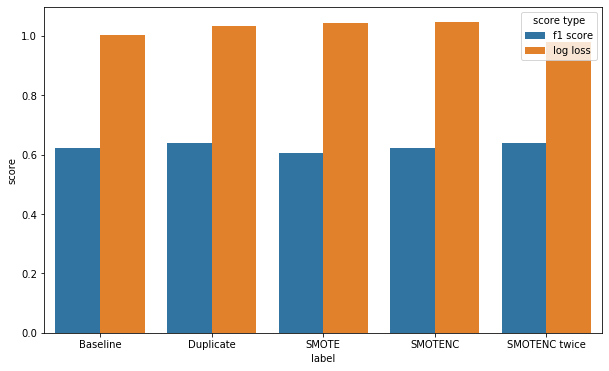

In [14]:
plt.figure(figsize=(10, 6))

sns.barplot(x="label", hue="score type", y="score", data=df)
plt.show()